# Quantum Travelling Salesman Problem
### Andre Rocco
### Arthur Carvalho

In the following notebook, we shall describe a phase oracle with the intention of identifying possible points of interest in optimizing the Travelling Salesman problem.

After that, a viable solution will be implemented using quantum parallelism, which will then be tested in quantum simulators and real quantum computers.

Lastly, we will test the performance of our implementation against widely known solutions in the classical computing sphere and comparing results."

### PART 1 - Describing a Phase Oracle

#### Describing the Travelling Salesman Problem

&nbsp;&nbsp;&nbsp;&nbsp;First, lets start by explaining what the travelling salesman problem entails:

&nbsp;&nbsp;&nbsp;&nbsp;The travelling Salesman Problem is a Np-hard problem which asks the following question:
        
&nbsp;&nbsp;&nbsp;&nbsp;"Given a list of locations and the distances between each pair of locations, what is the shortest possible route that visits each location exactly once and returns to the origin location?"

&nbsp;&nbsp;&nbsp;&nbsp;See the image below for a visual representation of a route in the travelling salesman problem:

<img src="Images/TSP_example.png">
    
&nbsp;&nbsp;&nbsp;&nbsp;As you can see, various points are laid out, similar to a map, and a route is traced between the points, with the last trace of the route being a connection between the last point and the origin location

&nbsp;&nbsp;&nbsp;&nbsp;With that in mind, a non-quantum computing solution to the problem uses a plethora of algorithms with the intention of finding the best route possible with the locations specified. Imagine that, for the solution of the problem, a user tries to employ an exhaustive search, a brute force algorithm which tests all the possible configurations of the parameters, so that the best possible route is found.

&nbsp;&nbsp;&nbsp;&nbsp;By doing so, an obvious problem arises: for every time the n number of locations that the algorithm will have to test is added upon, the number of possible routes raises exponentially, and, with a large enough number of n locations, trying to brute force a solution with regular computing becomes unfeasible.

&nbsp;&nbsp;&nbsp;&nbsp;Even with a non brute force algorithm, using certain heuristics, a feasible solution starts becoming harder every time the number of locations rises with the possible configurations of routes.

#### Time complexity of the Travelling Salesman Problem

&nbsp;&nbsp;&nbsp;&nbsp;Considering the Travelling Salesman Problem as a NP-hard problem, the computational, and therefore, the time complexity of the problem is one of imense proportions.

&nbsp;&nbsp;&nbsp;&nbsp;By adopting a brute force algorithm, where an exhaustive search is employed in order to check every possible combination of routes possible, the time complexity turns out to O(n!), because each time a new node is added to the existing nodes, the possible routes increases factorially.

&nbsp;&nbsp;&nbsp;&nbsp;It is also possible to adopt an optimization for the problem in classical computing, such as the Held Karp algorithm. The Held Karp algortihm proposes that the route should be divided into sub-routes, where, if a particular sub-route is found to be optimal, we could find in lesser time the optimal route of the problem as a whole by adding the multiple optimal stretches in a route. See the example below:

    Optimal Path P connects cities A-D while passing through C and E.
    Optimal Path Q connects cities D-G while passing through F and B
    Optimal Path R connects cities G and A

&nbsp;&nbsp;&nbsp;&nbsp;in an algorithm as such, by utilizing parallelism and other tools to hastily apply the parameters in an optimal fashion, the time complexity of the problem narrows down to O($2^n$ * n²), but, in order to satisfy the higher load of data being generated by the algorithm, O(2$n^n$) space is required, whereas the brute force method requires only O($n^2$) space.


#### Using a Phase Oracle for optimization 

&nbsp;&nbsp;&nbsp;&nbsp;A Phase Oracle is a device in quantum computing which utilizes phase shifts on quantum states to encode solutions to a problem. When using a Phase Oracle, if a solution is deemed worthy, the phase shift is applied, and, if not, no phase shift or a phase shift of different size is applied.

&nbsp;&nbsp;&nbsp;&nbsp;In regards to the Travelling Salesman Problem, a method of optimization can be achieved with the following steps:

    - A route (e.g. A-B-C-A) can be labelled as a quantum state;
    - A phase shift is applied to the states. The phase shift depends on the total distance of the route, with shorter routes receiving a smaller phase;
    - Quantum parallelism is applied to speed up the processing power of the algorithm;
    - Amplitude Amplification is applied to have better odds of finding the best route;
    - The route with smallest phase is chosen as the optimal route.

&nbsp;&nbsp;&nbsp;&nbsp;By applying the method above, which is commonly reffered to as a Grover's algorithm, quadratic speedup can be achieved, meaning that if an algorithm runs in O(n) time complexity, with this method the complexity shrinks to O($\sqrt{n}$).

&nbsp;&nbsp;&nbsp;&nbsp;The principal challenge that arises in utilizing such an algorithm stems from the fact that, in order to correctly implement a phase oracle, it is required to have a trustworthy calculation of the quality of the solution in superposition, and that may configure itself to be both complex and resource intensive.


### PART 2 - Implementing a solution using Quantum Parallelism

In [2]:
import numpy as np
from scipy.optimize import minimize
import cirq
from scipy import linalg
import matplotlib.pyplot as plt

%matplotlib inline

def points_order_to_binary_state(points_order):
    number_of_points = len(points_order)
    binary_state = np.zeros((len(points_order))**2)
    for j in range(len(points_order)):
        p = points_order[j]
        binary_state[(number_of_points) * (j) + (p)] = 1
    return binary_state

def binary_state_to_points_order(binary_state):
    points_order = []
    number_of_points = int(np.sqrt(len(binary_state)))
    for p in range(number_of_points):
        for j in range(number_of_points):
            if binary_state[(number_of_points) * p + j] == 1:
                points_order.append(j)
    return points_order

In [3]:
def get_distance_matrix(cities):
    number_of_cities = len(cities)
    matrix = np.zeros((number_of_cities, number_of_cities))
    for i in range(number_of_cities):
        for j in range(i, number_of_cities):
            matrix[i][j] = distance_between_points(cities[i], cities[j])
            matrix[j][i] = matrix[i][j]
    return matrix

def distance_between_points(point_A, point_B):
    return np.sqrt((point_A[0] - point_B[0])**2 + (point_A[1] - point_B[1])**2)

cities = np.array([[0, 4],[0, 0],[3, 0]])
distance_matrix = get_distance_matrix(cities)
number_of_cities = len(cities)

In [4]:
def create_cost_ham(qubits, qc_qaoa, gamma):
    number_of_cities = len(cities)
    for i in range(number_of_cities):
        for j in range(i, number_of_cities):
            for t in range(number_of_cities - 1):
                if distance_matrix[i][j] != 0:
                    weight = distance_matrix[i][j]/2
                    q1 = t * number_of_cities + i 
                    q2 = (t + 1) * number_of_cities + j
                    qc_qaoa.append(cirq.ZZPowGate(exponent=gamma*weight / np.pi, global_shift=-0.5).on(qubits[q1], qubits[q2]))
    
    weight = 10*np.max(distance_matrix)


    number_of_nodes = len(distance_matrix[0])
    for t in range(number_of_nodes):
        range_of_qubits = list(range(t * number_of_nodes, (t + 1) * number_of_nodes))
        qc_qaoa.append(cirq.DiagonalGate(diag_angles_radians=[x*gamma*weight for x in [1, 0, 0, 1, 0, 1, 1, 1]]).on(*[qubits[i] for i in range_of_qubits]))
        
    for i in range(number_of_nodes):
        range_of_qubits = list(range(i, number_of_nodes**2, number_of_nodes))
        qc_qaoa.append(cirq.DiagonalGate(diag_angles_radians=[x*gamma*weight for x in [1, 0, 0, 1, 0, 1, 1, 1]]).on(*[qubits[i] for i in range_of_qubits]))
    
    return qc_qaoa

def create_mix_ham(qubits, qc_qaoa, beta):
    for i in range(len(qubits)):
        qc_qaoa.append(cirq.rx(rads=beta).on(qubits[i]))
    return qc_qaoa

def create_qaoa_circuit(nqubits, theta):
    qc_qaoa = cirq.Circuit()
    qubits = cirq.LineQubit.range(nqubits)
    beta = theta[:int(len(theta)/2)]
    gamma = theta[int(len(theta)/2):]
    nqubits = len(cities)**2
    
    for i in range(nqubits):
        qc_qaoa.append(cirq.H.on(qubits[i]))
    
    for i in range(len(beta)):
        create_cost_ham(qubits, qc_qaoa, gamma[i])
        create_mix_ham(qubits, qc_qaoa, beta[i])

    qc_qaoa.append(cirq.measure(*qubits, key='result'))
    return qc_qaoa

In [5]:
def compute_expectation(counts, distance_matrix):
    avg = 0
    sum_count = 0
    counts_list = []
    for i in range(0, 2**9):
        counts_list.append((list(np.binary_repr(i, width=9)), counts[i]))
    counts_list = [(binary_state_to_points_order([int(i) for i in x[0]]), x[0], x[1]) for x in counts_list]
    for item in counts_list:
        path = item[0]
        bitstring = item[1]
        count = item[2]

        total = 0
        weight = 10*np.max(distance_matrix)

        for i in range(len(path) - 1):
            total += distance_matrix[path[i]][path[i+1]]

        times = [bitstring[i:i + 3] for i in range(0, len(bitstring), 3)]
        locations = [bitstring[i::3] for i in range(len(cities))]
        for time in times:
            if list(time).count('1')!=1:
                total += weight
                break
        for location in locations:
            if list(location).count('1')!=1:
                total += weight
                break

        avg += total * count
        sum_count += count
    return avg/sum_count

def get_expectation(distance_matrix):
    s = cirq.Simulator()

    def execute_circ(theta):
        qc = create_qaoa_circuit(len(distance_matrix[0])**2, theta)
        counts = s.run(qc, repetitions=1000).histogram(key='result')
        
        return compute_expectation(counts, distance_matrix)
    
    return execute_circ

In [6]:
np.random.seed(42)

results = []
for p in range(1, 10):
    result = 0
    for _ in range(10):  # Reduced to 10 for testing
        expectation = get_expectation(distance_matrix)

        lb = np.zeros(2*p)
        ub = np.hstack([np.full(p, np.pi), np.full(p, 2*np.pi)])
        
        # Initialize theta with random values within bounds
        init_point = np.random.uniform(lb, ub)

        # Add a maximum number of iterations to the optimizer
        res = minimize(expectation, 
                       init_point, 
                       method='COBYLA', 
                       tol=10e-6, 
                       options={'maxiter': 100})  # Max iterations set to 100 for testing

        result += res.fun
        print(f"Iteration for p={p}, result={res.fun}")  # Logging for debugging

    results.append(result/10)  # Adjusted to 10 for consistency

print(results)

Iteration for p=1, result=104.194
Iteration for p=1, result=103.138
Iteration for p=1, result=98.43
Iteration for p=1, result=103.605
Iteration for p=1, result=102.216
Iteration for p=1, result=103.485
Iteration for p=1, result=105.025
Iteration for p=1, result=101.763
Iteration for p=1, result=99.513
Iteration for p=1, result=101.836
Iteration for p=2, result=102.672
Iteration for p=2, result=104.864
Iteration for p=2, result=104.152
Iteration for p=2, result=92.07
Iteration for p=2, result=103.32
Iteration for p=2, result=104.659
Iteration for p=2, result=99.291
Iteration for p=2, result=88.917
Iteration for p=2, result=106.199
Iteration for p=2, result=102.494
Iteration for p=3, result=102.266
Iteration for p=3, result=103.284
Iteration for p=3, result=103.187
Iteration for p=3, result=102.375
Iteration for p=3, result=100.399
Iteration for p=3, result=103.16
Iteration for p=3, result=105.974
Iteration for p=3, result=101.426
Iteration for p=3, result=103.212
Iteration for p=3, resu

In [7]:
best = res.x
print(best)

[ 3.38756883  2.26336061  1.95405744 -0.13514941  1.4120074   3.36063865
  2.53137965  2.20585527  1.47628131  1.57320517  4.67176683  5.73580068
  4.24600481  3.15218554  5.93731898  6.13074196  6.86550566  6.77079778]


In [8]:
np.random.seed()

s = cirq.Simulator()
qc_res = create_qaoa_circuit(len(distance_matrix[0])**2, best)
counts = s.run(qc_res, repetitions=10000).histogram(key='result')

counts_list = []
counts_list1 = []
for i in range(0, 2**9):
    counts_list.append((list(np.binary_repr(i, width=9)), counts[i]))
    counts_list1.append((np.binary_repr(i, width=9), counts[i]))
counts_list1.sort(key=lambda x: -x[1])
print(counts_list1[:10])
counts_list = [(binary_state_to_points_order([int(i) for i in x[0]]), x[1]) for x in counts_list]
counts_list.sort(key=lambda x: -x[1])
print(counts_list[:10])

[('001100010', 135), ('100110001', 133), ('110101000', 126), ('110010011', 125), ('000100011', 124), ('010100010', 122), ('000110001', 118), ('100010000', 113), ('000111010', 111), ('100100011', 101)]
[([2, 0, 1], 135), ([0, 0, 1, 2], 133), ([0, 1, 0, 2], 126), ([0, 1, 1, 1, 2], 125), ([0, 1, 2], 124), ([1, 0, 1], 122), ([0, 1, 2], 118), ([0, 1], 113), ([0, 1, 2, 1], 111), ([0, 0, 1, 2], 101)]


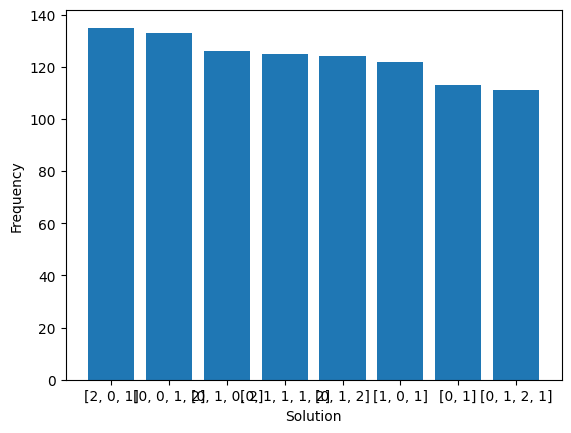

In [9]:
data = [x[1] for x in counts_list[:10]]

plt.bar([str(x[0]) for x in counts_list[:10]],[x[1] for x in counts_list[:10]])
plt.xlabel("Solution")
plt.ylabel("Frequency")
plt.savefig("histogram.png")

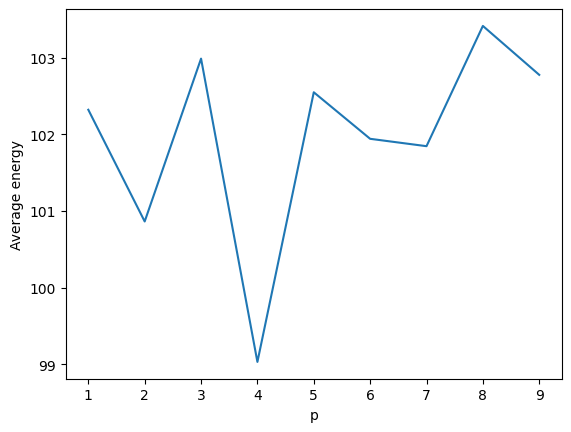

In [10]:
plt.plot([x for x in range(1,10)], [102.32050000000001, 100.8638, 102.98740000000001, 99.03229999999999, 102.5486, 101.94170000000001, 101.8456, 103.4138, 102.77579999999998])
plt.xlabel("p")
plt.ylabel("Average energy")
plt.savefig("p_dependence.png")

### PART 3 - Comparing results with Classical Computing

For comparisons, let us use the two methods described earlier in the document as benchmarks: the brute force algorithm and the held-karp algorithm.

#### Brute force Algorithm

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def create_cities(N):
    """
    Creates an array of random points of size N.
    """
    cities = []
    for i in range(N):
        cities.append(np.random.rand(2) * 10)
    return np.array(cities)

cities = create_cities(4)

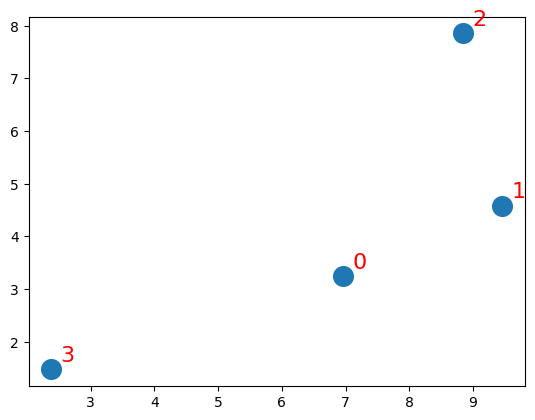

In [12]:
from Scripts.plots import plot_cities
plot_cities(cities)

In [13]:
import itertools

def distance_between_points(point_A, point_B):
    return np.sqrt((point_A[0] - point_B[0])**2 + (point_A[1] - point_B[1])**2)

def get_distance_matrix(cities):
    number_of_cities = len(cities)
    matrix = np.zeros((number_of_cities, number_of_cities))
    for i in range(number_of_cities):
        for j in range(i, number_of_cities):
            matrix[i][j] = distance_between_points(cities[i], cities[j])
            matrix[j][i] = matrix[i][j]
    return matrix

In [14]:
distance_matrix = get_distance_matrix(cities)
print(distance_matrix)

[[0.         2.82456452 4.97504915 4.9158768 ]
 [2.82456452 0.         3.3301853  7.7268073 ]
 [4.97504915 3.3301853  0.         9.08034145]
 [4.9158768  7.7268073  9.08034145 0.        ]]


In [15]:
def calculate_cost(cost_matrix, solution):
    cost = 0
    # I skiped one pair (first, last), since we don't care about returning to the starting point
    return sum([cost_matrix[a][b] for a, b  in zip(solution[:-1], solution[1:])])


def solve_tsp_brute_force(cities, starting_city, verbose=True):
    number_of_cities = len(cities)
    initial_order = range(number_of_cities)
    cost_matrix = get_distance_matrix(cities)
    
    # We create all the possible routes
    all_permutations = [list(x) for x in itertools.permutations(initial_order)]
    best_permutation = all_permutations[0]
    best_cost = calculate_cost(cost_matrix, best_permutation)*1000
    
    # We iterate through all the permutations and calculate their cost
    for permutation in all_permutations:
        if permutation[0] != starting_city:
            continue
        current_cost = calculate_cost(cost_matrix, permutation)
        if current_cost < best_cost:
            best_permutation = permutation
            best_cost = current_cost
    if verbose:
        print("Best route:", best_permutation)
        print("Cost:", best_cost)
    return best_permutation

In [16]:
solution = solve_tsp_brute_force(cities, 0)

Best route: [0, 1, 2, 3]
Cost: 15.235091271162547


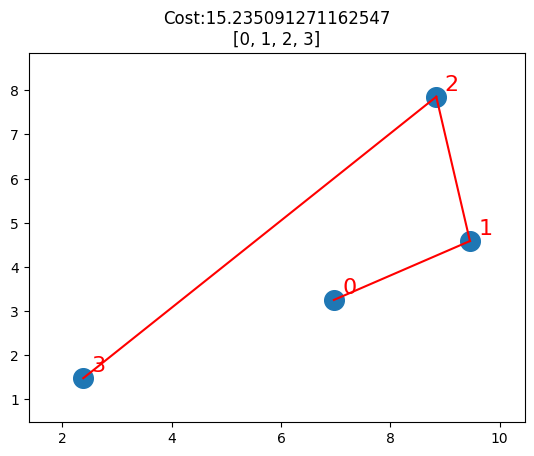

In [17]:
from Scripts.plots import plot_solution
plot_solution(cities, solution)

Best route: [0, 4, 1, 5, 2, 3]
Cost: 14.162321156575462


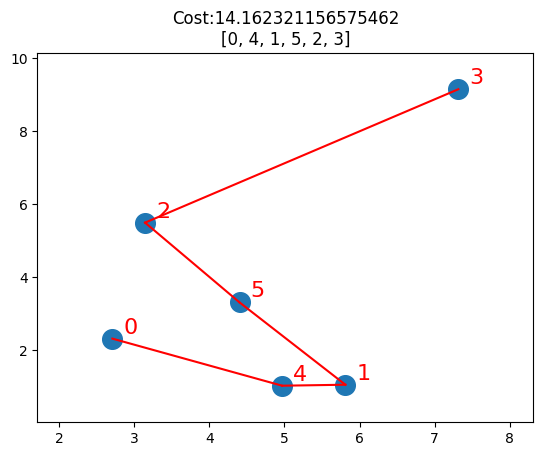

In [18]:
cities_6 = create_cities(6)
solution = solve_tsp_brute_force(cities_6, 0)
plot_solution(cities_6, solution)

Best route: [0, 2, 6, 4, 8, 3, 9, 5, 1, 7]
Cost: 25.391552462151175


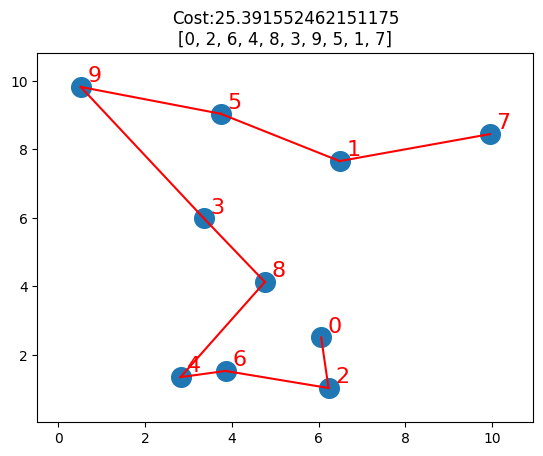

In [19]:
cities_10 = create_cities(10)
solution = solve_tsp_brute_force(cities_10, 0)
plot_solution(cities_10, solution)

In [20]:
for i in range(4, 10):
    print(i, "cities")
    %time solution = solve_tsp_brute_force(create_cities(i), 0, verbose=False)

4 cities
CPU times: user 358 µs, sys: 9 µs, total: 367 µs
Wall time: 140 µs
5 cities
CPU times: user 259 µs, sys: 6 µs, total: 265 µs
Wall time: 84.4 µs
6 cities
CPU times: user 1.07 ms, sys: 26 µs, total: 1.1 ms
Wall time: 380 µs
7 cities
CPU times: user 5.88 ms, sys: 141 µs, total: 6.02 ms
Wall time: 2.01 ms
8 cities
CPU times: user 14.4 ms, sys: 27.3 ms, total: 41.7 ms
Wall time: 13.8 ms
9 cities
CPU times: user 115 ms, sys: 12.1 ms, total: 127 ms
Wall time: 117 ms


3 cities
16.8 µs ± 4.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4 cities
24.5 µs ± 820 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
5 cities
54 µs ± 347 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
6 cities
200 µs ± 3.09 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7 cities
1.2 ms ± 1.86 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8 cities
9.35 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


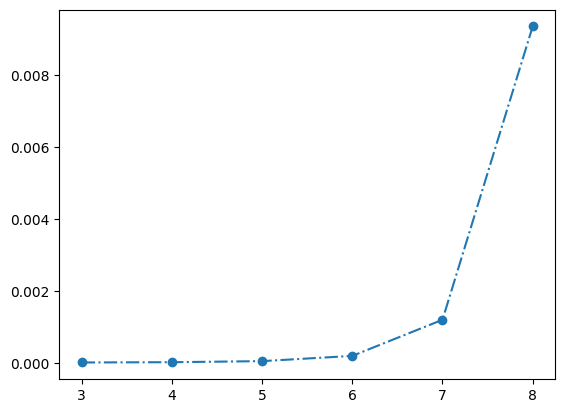

In [21]:
calculation_times = []
city_sizes = range(3, 9)

for i in city_sizes:
    print(i, "cities")
    calc_time = %timeit -o -n 100 solve_tsp_brute_force(create_cities(i), 0, verbose=False) 
    calculation_times.append(calc_time.average)

plt.plot(list(city_sizes), calculation_times, 'o-.')

In [22]:
from Scripts import simulated_annealing 
from Scripts.simulated_annealing import SimulatedAnnealer

def solve_tsp_simulated_annealing(cities, starting_city):
    sa = SimulatedAnnealer(cities, stopping_iter=5000, starting_city=starting_city)
    sa.anneal()
    solution = sa.get_best_solution()

    return solution

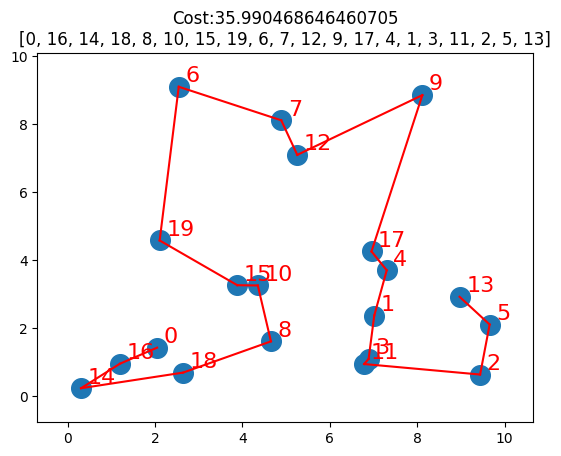

In [23]:
cities = create_cities(20)
sa_solution = solve_tsp_simulated_annealing(cities, 0)
plot_solution(cities, sa_solution)

In [24]:
import random

def generate_distance_matrix(size):
    matrix = [[0 if i == j else random.randint(10, 100) for j in range(size)] for i in range(size)]
    return matrix

# Use this to generate a 13x13 matrix
distance_matrix_13x13 = generate_distance_matrix(9)
distance_matrix_13x13

[[0, 88, 48, 45, 89, 23, 56, 17, 66],
 [55, 0, 98, 92, 98, 96, 45, 91, 25],
 [20, 34, 0, 11, 19, 45, 72, 44, 29],
 [89, 87, 48, 0, 54, 96, 54, 27, 22],
 [53, 13, 88, 74, 0, 55, 66, 24, 96],
 [97, 95, 84, 93, 16, 0, 22, 93, 87],
 [40, 17, 51, 70, 24, 24, 0, 86, 16],
 [21, 58, 99, 88, 59, 24, 44, 0, 76],
 [90, 44, 35, 54, 44, 28, 68, 45, 0]]

In [25]:
from itertools import permutations
import time

# Function to calculate the total distance of a tour
def calculate_distance(tour, distance_matrix):
    total_distance = 0
    for i in range(len(tour)):
        total_distance += distance_matrix[tour[i-1]][tour[i]]
    return total_distance

# Brute force function for TSP
def tsp_brute_force(distance_matrix):
    n = len(distance_matrix)
    # Generate all possible tours
    tours = permutations(range(n))
    min_distance = float('inf')
    min_tour = None

    # Iterate over all tours and find the one with the smallest distance
    for tour in tours:
        current_distance = calculate_distance(tour, distance_matrix)
        if current_distance < min_distance:
            min_distance = current_distance
            min_tour = tour

    return min_tour, min_distance

# Example usage


start_time = time.time()

# Run the TSP brute force algorithm
min_tour, min_distance = tsp_brute_force(distance_matrix_13x13)

# End the timer
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

print("Minimum tour:", min_tour)
print("Minimum distance:", min_distance)
print("Time taken: {:.2f} seconds".format(time_taken))


Minimum tour: (0, 5, 6, 4, 1, 8, 2, 3, 7)
Minimum distance: 201
Time taken: 0.22 seconds


#### Held-Karp Algorithm

In [26]:
from itertools import combinations

def held_karp(distances):
    n = len(distances)
    C = {}

    # Set initial values
    for k in range(1, n):
        C[(1 << k, k)] = (distances[0][k], 0)

    # Iterate through subsets of increasing length and keep track of minimum distances
    for subset_size in range(2, n):
        for subset in combinations(range(1, n), subset_size):
            bits = 0
            for bit in subset:
                bits |= 1 << bit

            for k in subset:
                prev = bits & ~(1 << k)

                res = []
                for m in subset:
                    if m == 0 or m == k:
                        continue
                    res.append((C[(prev, m)][0] + distances[m][k], m))
                C[(bits, k)] = min(res)

    bits = (2**n - 1) - 1

    # Look for optimal solution
    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + distances[k][0], k))
    opt, parent = min(res)

    # Backtrack to find full path
    path = []
    for i in range(n - 1):
        path.append(parent)
        new_bits = bits & ~(1 << parent)
        _, parent = C[(bits, parent)]
        bits = new_bits

    # Add start and end points
    path.append(0)

    return opt, list(reversed(path))

# Example usage

start_time = time.time()

# Run the TSP brute force algorithm
cost, path = held_karp(distance_matrix_13x13)

# End the timer
end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time

print(f"Minimum cost: {cost}")
print(f"Path: {path}")
print("Time taken: {:.2f} seconds".format(time_taken))


Minimum cost: 201
Path: [0, 5, 6, 4, 1, 8, 2, 3, 7]
Time taken: 0.00 seconds


### PART 5 - Conclusion

In conclusion, the following statements can be made when comparing the three algorithms seen above:
    
    1 - Brute Force Approach: This is the most straightforward but least efficient method for solving TSP. It exhaustively searches all possible permutations to find the shortest path. While it guarantees an optimal solution, its computational complexity is factorial (O(n!)), making it impractical for large datasets. It serves as a baseline for evaluating the performance of more sophisticated algorithms.

    2 - Held-Karp Algorithm: An advanced dynamic programming approach, Held-Karp significantly reduces the computational complexity compared to brute force, achieving a time complexity of O(n^2 * 2^n). This algorithm provides an exact solution and is much more feasible for moderately sized problems. However, its exponential growth rate in time complexity still limits its practicality for very large instances of TSP.

    3 - Quantum Approximate Optimization Algorithm (QAOA): QAOA represents a novel approach leveraging quantum computing principles. It is designed to find good approximate solutions to combinatorial problems like TSP, potentially in less time than classical algorithms for certain problem sizes. The performance and efficiency of QAOA depend heavily on quantum hardware advancements and algorithmic improvements. It holds promise for outperforming classical approaches in future, especially as quantum computing matures.

In summary, while brute force is simple and exact, it's computationally prohibitive for large TSP instances. Held-Karp optimizes this with a more efficient exact solution, suitable for medium-scale problems. QAOA, on the other hand, aims to revolutionize TSP solving by harnessing quantum computing, offering potential speed advantages for large-scale problems, though its current effectiveness is tied to the ongoing development of quantum technologies.